<a href="https://colab.research.google.com/github/Tony5t4rk/ML-2021-Spring/blob/main/Self_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 4 - Classify the speakers**

Author: Yang Liu

Study notes：[機器學習2021 学习笔记-CNN & Self-Attention](https://www.wolai.com/tony5t4rk/jFYeVKmHKnfwJyLEK18Gbh)

This program is modified based on [Sample Code](https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW04/HW04.ipynb)。

# Show GPU

In [69]:
!nvidia-smi

Tue Jun 15 03:03:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    34W / 250W |   3963MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Package

In [70]:
import numpy as np
import os
import csv
import json
import random
import gc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# set a random seed for reproducibility
my_seed = 42096
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(my_seed)
torch.manual_seed(my_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(my_seed)

# Download Data from Google Drive

In [71]:
!rm -rf ./sample_data

if not os.path.exists('Dataset.zip'):
    !gdown --id '1xW1Ozj21hLCA8MVIoyHTQDMRPjineNaC' --output Dataset.zip
if not os.path.exists('Dataset'):
    !unzip Dataset.zip > /dev/null 2>&1

!ls

mapping_file = 'Dataset/mapping.json'
metadata_file = 'Dataset/metadata.json'
testdata_file = 'Dataset/testdata.json'

 Dataset       drive					     models
 Dataset.zip  'Learning curve of Self-Attention Model.svg'   VoxCeleb.pred.csv


# Plot Utility

In [72]:
def plot_learning_curve(loss_record, title=''):
    n_epochs = len(loss_record['train'])
    x_1 = range(n_epochs)
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_1, loss_record['val'], c='tab:cyan', label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.savefig('Learning curve of {}.svg'.format(title))
    plt.show()

# Hyper-Parameters

In [73]:
os.makedirs('models', exist_ok=True)

config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'val_ratio': 0.1,
    'n_epochs': 80,
    'batch_size': 512,
    'optim_hparams': {
        'lr': 0.001,
        'weight_decay': 0.00001
    },
    'early_stop': False,
    'early_stop_epochs': 10,
    'best_model': True,
    'model_path': 'models/model.pth',
    'pred_file': 'VoxCeleb.pred.csv'
}

print(f'device: {config["device"]}')

device: cuda


# Data Process

## Dataset

In [74]:
class VoxCeleb_Dataset(Dataset):
    def __init__(self, segment_len=128):
        self.segment_len = 128

        with open(mapping_file) as fp:
            mapping = json.load(fp)
            self.speaker2id = mapping['speaker2id']

        with open(metadata_file) as fp:
            metadata = json.load(fp)
            self.mel_dim = metadata['n_mels']
            self.speakers = metadata['speakers']

        self.data, self.label = [], []
        for speaker, features in self.speakers.items():
            for feature in features:
                self.data.append(feature['feature_path'])
                self.label.append(self.speaker2id[speaker])
    
    def __getitem__(self, index):
        feature_path, speaker = self.data[index], self.label[index]
        mel = torch.load(os.path.join('Dataset', feature_path))

        if len(mel) > self.segment_len:
            start = random.randint(0, len(mel) - self.segment_len)
            mel = torch.FloatTensor(mel[start:start + self.segment_len])
        else:
            mel = torch.FloatTensor(mel)
        speaker = torch.LongTensor([speaker])

        return mel, speaker
    
    def __len__(self):
        return len(self.data)

train_dataset = VoxCeleb_Dataset()
val_length = int(config['val_ratio'] * len(train_dataset))
train_dataset, val_dataset = random_split(train_dataset, [len(train_dataset) - val_length, val_length])

print(f'Train Dataset: {len(train_dataset)} samples')
print(f'Valid Dataset: {len(val_dataset)} samples')

Train Dataset: 62495 samples
Valid Dataset: 6943 samples


In [75]:
class VoxCeleb_Test_Dataset(Dataset):
    def __init__(self):
        with open(testdata_file) as fp:
            metadata = json.load(fp)
            self.data = metadata['utterances']

    def __getitem__(self, index):
        feature_path = self.data[index]['feature_path']
        mel = torch.load(os.path.join('Dataset', feature_path))
        return feature_path, mel
    
    def __len__(self):
        return len(self.data)

test_dataset = VoxCeleb_Test_Dataset()

print(f'Test Dataset: {len(test_dataset)} samples')

gc.collect()

Test Dataset: 6000 samples


2924

## DataLoader

In [76]:
def collate_batch(batch):
    mel, speaker = zip(*batch)
    mel = pad_sequence(mel, batch_first=True, padding_value=-20)
    return mel, torch.LongTensor(speaker)

train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=True, collate_fn=collate_batch)

In [77]:
def test_collate_batch(batch):
    feature_path, mel = zip(*batch)
    return feature_path, torch.stack(mel)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False, collate_fn=test_collate_batch)

# Model

In [78]:
class Net(nn.Module):
    def __init__(self, input_dim, d_model=80, p=0.1):
        super(Net, self).__init__()

        self.pre_net = nn.Sequential(
            nn.Linear(input_dim, d_model)
        )

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                dim_feedforward=256,
                nhead=2
            ),
            num_layers=2
        )

        self.output_fc = nn.Sequential(
            nn.Linear(d_model, 600)
        )

    def forward(self, x):
        x = self.pre_net(x)
        x = x.permute(1, 0, 2)
        x = self.encoder(x)
        x = x.transpose(0, 1)
        x = x.mean(dim=1) # mean pooling
        x = self.output_fc(x)
        return x

model = Net(train_dataset.dataset.mel_dim).to(config['device'])

# Training

In [79]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), **config['optim_hparams'])

In [80]:
loss_record = {'train': [], 'val': []}

if config['early_stop']:
    early_stop_cnt = 0

min_val_loss = float('inf')

epoch = 0
while epoch < config['n_epochs']:
    model.train()
    train_loss = []
    for x, y in train_dataloader:
        x, y = x.to(config['device']), y.to(config['device'])
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_loss = sum(train_loss) / len(train_loss)
    loss_record['train'].append(train_loss)

    model.eval()
    val_loss = []
    for x, y in val_dataloader:
        x, y = x.to(config['device']), y.to(config['device'])
        with torch.no_grad():
            logits = model(x)
            loss = criterion(logits, y)
        val_loss.append(loss)
    val_loss = sum(val_loss) / len(val_loss)
    loss_record['val'].append(val_loss)

    if config['best_model']:
        if val_loss < min_val_loss:
            torch.save(model, config['model_path'])
    else:
        torch.save(model, config['model_path'])
    
    print(f'[ Epoch {epoch + 1:03d}/{config["n_epochs"]:03d} ] Train Loss: {train_loss:.5f} Valid Loss: {val_loss:.5f}')

    if config['early_stop']:
        if val_loss < min_val_loss:
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1
    
    epoch += 1
    if val_loss < min_val_loss:
        min_val_loss = val_loss

    if config['early_stop'] and early_stop_cnt > config['early_stop_epochs']:
        break

print(f'Finish Train After {epoch} Epochs')

[ Epoch 001/080 ] Train Loss: 5.60194 Valid Loss: 4.81987
[ Epoch 002/080 ] Train Loss: 4.39307 Valid Loss: 4.00180
[ Epoch 003/080 ] Train Loss: 3.69782 Valid Loss: 3.48274
[ Epoch 004/080 ] Train Loss: 3.21772 Valid Loss: 3.06093
[ Epoch 005/080 ] Train Loss: 2.91894 Valid Loss: 2.82252
[ Epoch 006/080 ] Train Loss: 2.69054 Valid Loss: 2.64440
[ Epoch 007/080 ] Train Loss: 2.51697 Valid Loss: 2.51479
[ Epoch 008/080 ] Train Loss: 2.37489 Valid Loss: 2.36333
[ Epoch 009/080 ] Train Loss: 2.24081 Valid Loss: 2.23709
[ Epoch 010/080 ] Train Loss: 2.12643 Valid Loss: 2.19576
[ Epoch 011/080 ] Train Loss: 2.03269 Valid Loss: 2.09081
[ Epoch 012/080 ] Train Loss: 1.93138 Valid Loss: 2.00742
[ Epoch 013/080 ] Train Loss: 1.84045 Valid Loss: 1.93877
[ Epoch 014/080 ] Train Loss: 1.75884 Valid Loss: 1.84528
[ Epoch 015/080 ] Train Loss: 1.68502 Valid Loss: 1.77694
[ Epoch 016/080 ] Train Loss: 1.62368 Valid Loss: 1.77221
[ Epoch 017/080 ] Train Loss: 1.55644 Valid Loss: 1.66933
[ Epoch 018/08

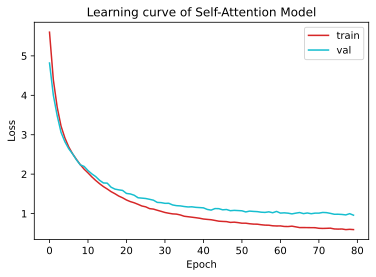

In [81]:
plot_learning_curve(loss_record, 'Self-Attention Model')

# Testing

In [82]:
if config['best_model']:
    del model
    model = torch.load(config['model_path']).to(config['device'])

In [83]:
with open(mapping_file) as fp:
    mapping = json.load(fp)

model.eval()
preds = []
for feature_path, mel in test_dataloader:
    mel = mel.to(config['device'])
    with torch.no_grad():
        logits = model(mel)
        pred = logits.argmax(dim=1).cpu().numpy()
    for x, y in zip(feature_path, pred):
        preds.append([x, mapping['id2speaker'][str(y)]])

In [84]:
print(f'Saving Result to {config["pred_file"]}')
with open(config['pred_file'], 'w') as fp:
    fp.write('Id,Category\n')
    for id, pred in preds:
        fp.write(f'{id},{pred}\n')

Saving Result to VoxCeleb.pred.csv


In [85]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r ./models '/content/drive/MyDrive/Colab/ML 2021 Spring/HW04/'
!cp ./*.pred.csv '/content/drive/MyDrive/Colab/ML 2021 Spring/HW04/'
!cp ./*.svg '/content/drive/MyDrive/Colab/ML 2021 Spring/HW04/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Result